# Modelación de flujo de agua subterránea en un medio heterogéneo/Planta con FEniCS

* Autor: Ricardo Balam Chagoya Morales


### Modelo conceptual

El modelo conceptual-teórico consiste en una porción de acuífero rectangular de 200 m en
dirección E-O y 100 m en dirección N-S que se extiende sobre un plano de ladera con echado
en dirección este, donde vamos a definir una sección con diferente material. La asignación de la conductividad
hidráulica que caracteriza al material se realiza con base en los resultados presentados por De
Marsily (1986). En este caso se tomará en cuenta dos modelos donde el medio
geológico corresponde a un cambio de facies de un material de grano grueso, de valor promedio
K = 100m=dia a un material de grano más fino con valor promedio K = 10m=dia, y el otro
modelo donde el cambio va de un material fino a un material más grueso.

<img src="../Tesis/Figura_25c.png" alt="Figura_25d.png" width="400"/>

### Modelo matemático

El cambio de facies se hace a partir de una linea diagonal en dirección Este-Oeste, a partir de estos valores
construimos la ecuación que representa la conductividad hidráulica en todo el dominio de la
siguiente forma:
    
   $$ k(x,y)= 100 \:\:  en  \:\: {\Omega}_{1} \\ $$
   $$ k(x,y)=  10 \:\: en \:\: {\Omega}_{2} \\ $$
   
Para el caso contrario se invierten los valores de conductividad hidráulica. Donde las condiciones de frontera son representadas por condiciones de Dirichlet en las fronteras Este-Oeste y condiciones de Neumann en las fronteras Norte-Sur.


 $$\nabla^{2}h(x,y)=0 \quad en \quad \Omega$$

 $$h(x,y)=100 \quad en \quad {\partial}{\Omega}_{D1}$$


 $$h(x,y)=10 \quad en \quad {\partial}{\Omega}_{D2}$$
 
 $${\nabla}h{\cdot}\textbf{n}=0 \quad en \quad {\partial}{\Omega}_{N} $$

Mientras que la ecuación que modela el problema es la siguiente:


 $${\nabla}k(x,y){\nabla}h(x,y)=0 \quad en \quad \Omega$$

Para obtener la solución de esta ecuación diferencial, se usará el método de elemento fínito y se hará la implementación computacional con la biblioteca FEniCS, como parámetro de entrada, es necesario obtener la formulación integral/ formulación débil de la ecuación de flujo.  La formulación integral se plantea a partir de la división del dominio $\Omega$ en subdominios con su propia conductividad hidráulica. Los subdominios y las fronteras del dominio quedan definidos de la siguiente manera:


 $${\Omega}_{1}=[0,100]{\times}[0,100] \: Subdominio \: 1 $$
 
 $${\Omega}_{2}=[100,200]{\times}[0,100] \: Subdominio \: 2 $$
 
 $${\partial}\Omega_{D}={(0,y){\cup}(200,y)} \: Condiciones \: de \: Dirichlet $$
 
 $${\partial}\Omega_{N}={(x,0){\cup}(x,100)} \: Condiciones \: de \: Neumann $$
 
La formulación integral del problema se obtiene sobre los dos subdominios, obteniendo la siguiente forma bilineal:


 $$a(h,v)=\int_{\Omega_{1}}^{} k_{1}{\nabla}h{\cdot}{\nabla}v \cdot ds+\int_{\Omega_{2}}^{} k_{2}{\nabla}h{\cdot}{\nabla}v \cdot ds $$


Mientras que la forma lineal de la formulación integral del problema al tener las mismas condiciones de fronteras es $L(v)=0$. La discretización del problema se realiza con el espacio de funciones polinomios de lagrange de grado 1.


### Modelo computacional

Para resolver esta ecuación, es necesario hacer la importación de todas las librerias necesarias, para este caso, fenics que contiene todas las funciones necesarias, numpy y matplotlib.

In [59]:
from __future__ import print_function
from fenics import *
import numpy as np
import matplotlib.pyplot as plt

Se definen las condiciones de frontera, la malla rectangular y el espacio de funciones con polinomios de lagrange de grado 1. (Para mayor detalle, consultar Caso homogeneo)

In [71]:
# Se definen los parámetros de la simulación

k1 = 10 #Conductividad hidráulica en la litología 1
k2 = 100 # Conductividad hidráulica en la litología 2 
lonx = 200 # Longitud en dirección x
lony = 100 # Longirud en dirección y
delta = 10 # Refinación de malla
elemx = int(lonx/delta) # Número de elementos en x
elemy = int(lony/delta) # Número de elementos en y

# Se definen las condiciones de fronteras

mesh= RectangleMesh(Point(0,0),Point(lonx,lony),elemx,elemy)
V = FunctionSpace(mesh, 'P', 1)

# Se definen las condiciones de fronteras

def frontera_I(x,frontera):
 tol=1E-14 
 if frontera:
  if abs(x[0])<=tol: 
   return True
  else:
   return False 
 else:
  return False  

def frontera_D(x,frontera):
 tol=1E-14 
 if frontera:
  if abs(x[0]-lonx)<=tol: 
   return True
  else:
   return False 
 else:
  return False 

F_I = DirichletBC(V,Constant(100), frontera_I)
F_D = DirichletBC(V,Constant(10), frontera_D)
bc = [F_I,F_D]

Para definir la heterogeneidad del dominio, se realiza de forma similar a las condiciones de Dirichlet. Primero se define una clase llamada K, cuyo constructor tiene como argumentos dos valores de conductividad (propiedades de la clase) y un método que delimita los subdominios y asigna para cada subdominio los valores de conductividad que le corresponde. Finalmente, se genera una instancia de esta clase y se ocupa el método set_k_values para obtener la conductividad en todo el dominio de la simulación. 

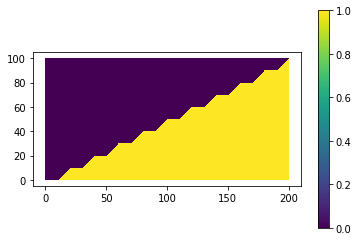

In [72]:
# Se define la heterogeneidad

class K(UserExpression):
 def set_k_values(self, k_1, k_2):
     self.k_1, self.k_2 = k_1, k_2
 def eval(self, value, x):
   tol = 1E-14 
   if  x[0] <= 2*x[1] + tol:
      value[0] = self.k_1
   else:
      value[0] = self.k_2

kappa = K(degree=1)
kappa.set_k_values(k1,k2)

# Otra forma de definir la heterogeneidad

class Omega0(SubDomain):
    def inside(self,x,on_boundary):
        return True if x[0] <= 2*x[1] else False
    
class Omega1(SubDomain):
    def inside(self,x,on_boundary):
        return True if x[0] >= 2*x[1] else False
    
subdomains = MeshFunction("size_t",mesh,2)
subdomain0 = Omega0()
subdomain0.mark(subdomains,0)
subdomain1 = Omega1()
subdomain1.mark(subdomains, 1)

plt.figure()
imgk = plot(subdomains)
plt.colorbar(imgk)

V0 = FunctionSpace(mesh, "DG", 0)
kappa = Function(V0)

k_values = [k1, k2] 
for cell_no in range(len(subdomains.array())):
  subdomain_no = subdomains.array()[cell_no]
  kappa.vector()[cell_no] = k_values[subdomain_no]
  #rint(cell_no)
  #print(kappa.vector()[cell_no])


Teniendo definida la malla, el espacio de funciones, las condiciones de frontera y el campo de conductividades hidráulicas; se generan la función de prueba *v* y la variable donde se depositará nuestra solución (*u*). Posteriormente, se definen la parte izquierda y derecha de la formulación integral/débil de la ecuación de flujo. En la parte izquierda, se encuentra la fuente (*f*) que en nuestro caso será nulo $f=0$ y se define en *L* la totalidad del lado izquierdo, mientras que en el lado derecho se encuentra la formulación restante (variable *a*). 

In [73]:
#Se define el problema variacional

u=TrialFunction(V)
v=TestFunction(V)
f=Constant(0)
a=kappa*dot(grad(u),grad(v))*dx
g=Constant(0)
L=f*v*dx-g*v*ds

In [74]:
# Se realiza el calculo de la solucion

u= Function(V)
solve(a==L,u,bc)
#plot(u)
#plot(-grad(u))

Se obtienen los centroides de cada elemento finito y se evalua para cada punto la descarga específica según la ley de Darcy y finalmente, se plotea el campo de cargas hidráulicas y la descarga específica.

$$q=-k{\nabla}h$$

In [75]:
# Se organizan los valores para la exportación de los datos

tau=project(grad(u))
xx=np.loadtxt("Coordenadascentroide.csv",delimiter=',',skiprows=1,usecols=[1])
yy=np.loadtxt("Coordenadascentroide.csv",delimiter=',',skiprows=1,usecols=[2])
datos=np.zeros((400,7))
datos[:,0]=xx
datos[:,1]=yy
datos[:,4]=1

# Se genera el cálculo del gradiente de carga hidráulica para cada centroide del elemento finito
for i in range(0,399):
 datos[i,2]=tau(xx[i],yy[i])[0]
 datos[i,3]=tau(xx[i],yy[i])[1]

np.savetxt("SoluciónFlujo3.2",datos)

In [76]:
# Se escribe en el arreglo para exportar en datos, la conductividad hidráulica
for i in range (0,399): 
 if (datos[i,0]<2*datos[i,1]):
  datos[i,4]=k1
 else:
  datos[i,4]=k2
# Se aplica la ecuación de Darcy

for cell_no in range(len(subdomains.array())):
  subdomain_no = subdomains.array()[cell_no]
  datos[cell_no,5] = k_values[subdomain_no]*datos[cell_no,2]
  datos[cell_no,6] = k_values[subdomain_no]*datos[cell_no,3]

  #datos[:,5]=k2*datos[:,2]
  #datos[:,6]=k1*datos[:,3]
  

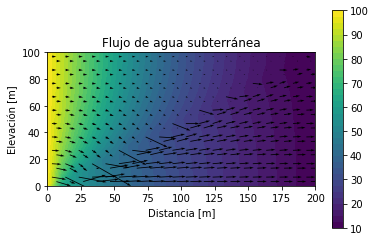

In [77]:
## Ploteando los resultados de la simulación, flujo en un medio de alta conductividad tratando de entrar a un medio de
## baja conductividad

carga=plot(u)
flujo=plt.quiver(xx,yy,-datos[:,5],-datos[:,6])
plt.colorbar(carga)
plt.title('Flujo de agua subterránea')
plt.ylabel('Elevación [m]')
#plt.colorbar(im)
#plot(mesh)
plt.title('Flujo de agua subterránea')
plt.ylabel('Elevación [m]')
plt.xlabel('Distancia [m]')
plt.show()


A partir del procedimiento anterior, se invierten los valores de conductividad hidráulica

In [78]:
### Invirtiendo los valores de conductividad

k_values = [k2, k1] 
for cell_no in range(len(subdomains.array())):
  subdomain_no = subdomains.array()[cell_no]
  kappa.vector()[cell_no] = k_values[subdomain_no]

In [79]:
# Se redefine la ecuación

u=TrialFunction(V)
v=TestFunction(V)
f=Constant(0)
a=kappa2*dot(grad(u),grad(v))*dx
g=Constant(0)
L=f*v*dx-g*v*ds

# Se realiza el calculo de la solucion

u= Function(V)
solve(a==L,u,bc)
tau=project(grad(u))

In [80]:
# Se organizan los valores para la exportación de los datos de esta simulación

tau=project(grad(u))
xx=np.loadtxt("Coordenadascentroide.csv",delimiter=',',skiprows=1,usecols=[1])
yy=np.loadtxt("Coordenadascentroide.csv",delimiter=',',skiprows=1,usecols=[2])
datos=np.zeros((400,7))
datos[:,0]=xx
datos[:,1]=yy
for i in range(0,399):
 datos[i,2]=tau(xx[i],yy[i])[0]
 datos[i,3]=tau(xx[i],yy[i])[1]

np.savetxt("SoluciónFlujo3.3",datos)

In [81]:
for i in range (0,399): 
 if (datos[i,0]<2*datos[i,1]):
  datos[i,4]=k1
 else:
  datos[i,4]=k2

# Se aplica la ecuación de Darcy
#datos[:,5]=k2*datos[:,2]
#datos[:,6]=k1*datos[:,3]

for cell_no in range(len(subdomains.array())):
  subdomain_no = subdomains.array()[cell_no]
  datos[cell_no,5] = k_values[subdomain_no]*datos[cell_no,2]
  datos[cell_no,6] = k_values[subdomain_no]*datos[cell_no,3]

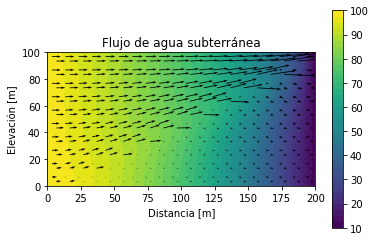

In [82]:
## Ploteando los resultados de la simulación, flujo en un medio de alta conductividad tratando de entrar a un medio de
## baja conductividad
import matplotlib.pyplot as plt
carga=plot(u)
flujo=plt.quiver(xx,yy,-datos[:,5],-datos[:,6])
plt.colorbar(carga)
plt.title('Flujo de agua subterránea')
plt.ylabel('Elevación [m]')
#plt.colorbar(im)
#plot(mesh)
plt.title('Flujo de agua subterránea')
plt.ylabel('Elevación [m]')
plt.xlabel('Distancia [m]')
plt.show()